<a href="https://colab.research.google.com/github/Ziforge/bird-net-batch-analysis/blob/main/AudacityTaggerBatchCompiler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐦 Bird Audio Analysis Notebook

This notebook processes batches of audio recordings into one file, analyzes them with **BirdNET**, and produces both **labels for Audacity** and **detailed visualizations (spectrograms, F0, F1–F3, etc.)**.

---

## 🔹 Workflow Overview

1. **Upload & Merge**  
   - Upload audio files  
   - Merge them end-to-end (no overlaps)  
   - Export: merged WAV, Audacity labels, index CSV  

2. **BirdNET Analysis**  
   - Run BirdNET on each original file  
   - Align detections to the merged timeline  
   - Export: detections CSV + Audacity labels  

3. **Visualize Detections**  
   - Generate waveform + spectrogram plots for each detection  
   - Extract F0, F1–F3 (formant-like peaks), spectral features  
   - Export: summary CSV + images  

4. **Overview Spectrogram**  
   - Produce one full-file spectrogram  
   - Overlay BirdNET detections as shaded spans with labels  

5. **Audacity**  
   - Open the merged WAV  
   - Import both label tracks (per-file + BirdNET)  
   - Switch to **Spectrogram View** to see detections aligned with sounds  

   

---

## 🔹 Notes

- Adjust BirdNET settings (`LAT`, `LON`, `DATE`, `MIN_CONF`) for best results.  
- `F0_MIN_HZ` / `F0_MAX_HZ` should match the expected pitch range of your species.  
- Formant estimates (F1–F3) are approximate **spectral resonances**, not true speech formants.  
- You can import both label files into Audacity to see **file boundaries** and **detections** at once.  

---

---
📄 **License**

This notebook and associated code are released under the **MIT License**  
© 2025 George Redpath. See full license text at the bottom of this notebook.
---

⚠️ **Credit:** If you are using this code, please credit **George Redpath**.  

Here is a Flow chart per Cell on what code does what for an analysis work flow

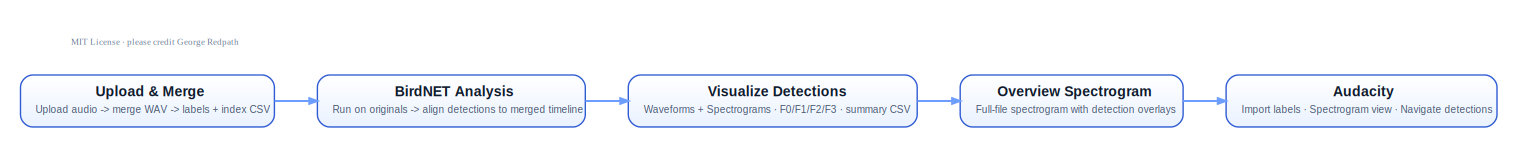

In [9]:
# ============================================================
# 🎨 Aesthetic Pipeline Diagram (Graphviz, inline SVG, HTML-safe)
# ============================================================

!apt-get -qq install graphviz
!pip -q install graphviz

from graphviz import Digraph
from IPython.display import SVG, display

# Theme: "light" or "dark"
THEME = "light"

# ---- palette ----
if THEME == "dark":
    bg         = "#0b1220"
    node_fill1 = "#1b2a4a"
    node_fill2 = "#0f1c34"
    node_edge  = "#5aa3ff"
    node_text  = "#e7efff"
    sub_text   = "#b8c7e6"
    edge_col   = "#7fb3ff"
    foot_text  = "#9fb7dd"
else:
    bg         = "#ffffff"
    node_fill1 = "#eaf2ff"
    node_fill2 = "#ffffff"
    node_edge  = "#2f5bd3"
    node_text  = "#0f1a2b"
    sub_text   = "#4a5a73"
    edge_col   = "#6d9eff"
    foot_text  = "#6b7b94"

# ---- helpers ----
def html_escape(s: str) -> str:
    # Graphviz HTML-like labels require escaping &, <, >
    return s.replace("&", "&amp;").replace("<", "&lt;").replace(">", "&gt;")

def card(graph: Digraph, node_id: str, title: str, subtitle: str):
    title = html_escape(title)
    subtitle = html_escape(subtitle)
    label = f'''<
      <TABLE BORDER="0" CELLBORDER="0" CELLSPACING="0">
        <TR><TD><FONT POINT-SIZE="14"><B>{title}</B></FONT></TD></TR>
        <TR><TD><FONT COLOR="{sub_text}" POINT-SIZE="10">{subtitle}</FONT></TD></TR>
      </TABLE>
    >'''
    graph.node(
        node_id,
        label=label,
        shape="box",
        style="rounded,filled",
        fillcolor=f"{node_fill1}:{node_fill2}",
        gradientangle="90",
        color=node_edge,
        penwidth="1.4",
        fontname="Helvetica",
        fontsize="12",
        fontcolor=node_text,
        margin="0.18,0.12"
    )

# ---- create graph ----
dot = Digraph("Bird_Audio_Workflow", format="svg")
dot.attr(
    rankdir="LR",
    splines="spline",
    bgcolor=bg,
    pad="0.25",
    nodesep="0.35",
    ranksep="0.6"
)
dot.attr("edge",
    color=edge_col,
    penwidth="2",
    arrowsize="0.8",
    arrowhead="normal"
)

# ---- nodes ----
card(dot, "A", "Upload & Merge", "Upload audio -> merge WAV -> labels + index CSV")
card(dot, "B", "BirdNET Analysis", "Run on originals -> align detections to merged timeline")
card(dot, "C", "Visualize Detections", "Waveforms + Spectrograms · F0/F1/F2/F3 · summary CSV")
card(dot, "D", "Overview Spectrogram", "Full-file spectrogram with detection overlays")
card(dot, "E", "Audacity", "Import labels · Spectrogram view · Navigate detections")

# ---- edges ----
dot.edge("A", "B")
dot.edge("B", "C")
dot.edge("C", "D")
dot.edge("D", "E")

# ---- footer credit (separate rank)
with dot.subgraph(name="cluster_legend") as s:
    s.attr(color="white")  # invisible box
    s.node("credit", label=f'''<
      <FONT POINT-SIZE="9" COLOR="{foot_text}">
        MIT License · please credit George Redpath
      </FONT>
    >''', shape="plain")

# Render inline
display(SVG(dot.pipe(format="svg")))

In [2]:
# =========================
# Upload audio files → Merge end-to-end (no overlaps) → Export + Labels for Audacity
# =========================

!apt -q update && apt -q install -y ffmpeg
!pip -q install pydub pandas

import os, glob
from pydub import AudioSegment
import pandas as pd
from google.colab import files

# ---- STEP 1: Upload files ----
upload_dir = "/content/uploads"
os.makedirs(upload_dir, exist_ok=True)

print("📂 Please select your audio files (you can select many at once).")
uploaded = files.upload()

for fn, data in uploaded.items():
    with open(os.path.join(upload_dir, fn), "wb") as f:
        f.write(data)

print(f"\n✅ Saved {len(uploaded)} files to {upload_dir}")

# ---- USER SETTINGS ----
AUDIO_DIR = upload_dir             # Folder with uploaded files
GLOB_PATTERN = "*"                 # Match all uploaded files
SORT_BY = "name"                   # "name" or "mtime"
GAP_BETWEEN_MS = 0                 # silence inserted between files (ms). 0 = back-to-back.
OUTPUT_BASENAME = "merged_no_overlap"
EXPORT_WAV = True
EXPORT_MP3 = False
MP3_BITRATE = "192k"

# Loudness & format controls (optional)
NORMALIZE_EACH = True                # normalize each file before concatenation
TARGET_DBF_S = -16.0
NORMALIZE_FINAL = True               # normalize the final mix
FINAL_TARGET_DBF_S = -14.0
FORCE_CHANNELS = 2                   # None to keep as-is; or 1 (mono) / 2 (stereo)
FORCE_SAMPLE_RATE = 44100            # None to keep as-is; typical: 44100 or 48000

# Label formatting (how labels will look inside Audacity)
LABEL_PREFIX = ""                    # e.g., "Part "
LABEL_SHOW_DURATION = True           # append duration to the label text
MAX_LABEL_BASENAME_CHARS = 60        # truncate long names in label text

# ---- Helpers ----
def load_segment(path):
    seg = AudioSegment.from_file(path)
    if NORMALIZE_EACH and seg.dBFS != float("-inf"):
        seg = seg.apply_gain(TARGET_DBF_S - seg.dBFS)
    if FORCE_CHANNELS in (1, 2):
        seg = seg.set_channels(FORCE_CHANNELS)
    if FORCE_SAMPLE_RATE:
        seg = seg.set_frame_rate(FORCE_SAMPLE_RATE)
    return seg

def fmt_time_hhmmss_ms(ms):
    s = ms / 1000.0
    m, sec = divmod(s, 60)
    h, m = divmod(m, 60)
    return f"{int(h):02d}:{int(m):02d}:{sec:06.3f}"

def sec(ms):  # Audacity labels need seconds (float)
    return ms / 1000.0

# ---- Collect files ----
files = [p for p in glob.glob(os.path.join(AUDIO_DIR, GLOB_PATTERN)) if os.path.isfile(p)]
if not files:
    raise SystemExit(f"No audio files found in {AUDIO_DIR} matching '{GLOB_PATTERN}'")

if SORT_BY == "mtime":
    files.sort(key=lambda p: os.path.getmtime(p))
else:
    files.sort(key=lambda p: os.path.basename(p).lower())

print(f"🔎 Found {len(files)} files to concatenate (no overlap).")

# ---- Build master end-to-end + capture label times ----
master = AudioSegment.silent(duration=0)
gap = AudioSegment.silent(duration=GAP_BETWEEN_MS) if GAP_BETWEEN_MS > 0 else None

labels = []   # for Audacity
index_rows = []  # for CSV

cursor_ms = 0
for i, path in enumerate(files, 1):
    base = os.path.basename(path)
    print(f"[{i}/{len(files)}] {base}")
    seg = load_segment(path)
    start_ms = cursor_ms
    end_ms = start_ms + len(seg)

    master += seg
    if gap and i < len(files):
        master += gap
        cursor_ms = end_ms + GAP_BETWEEN_MS
    else:
        cursor_ms = end_ms

    # Label text
    display_name = os.path.splitext(base)[0][:MAX_LABEL_BASENAME_CHARS]
    label_text = f"{LABEL_PREFIX}{i:03d} - {display_name}"
    if LABEL_SHOW_DURATION:
        label_text += f" ({fmt_time_hhmmss_ms(len(seg))})"

    labels.append((sec(start_ms), sec(end_ms), label_text))
    index_rows.append({
        "index": i,
        "filename": base,
        "start_ms": start_ms,
        "end_ms": end_ms,
        "duration_ms": len(seg),
        "start_hms": fmt_time_hhmmss_ms(start_ms),
        "end_hms": fmt_time_hhmmss_ms(end_ms),
        "duration_hms": fmt_time_hhmmss_ms(len(seg)),
    })

# ---- Normalize final output if desired ----
if NORMALIZE_FINAL and master.dBFS != float("-inf"):
    master = master.apply_gain(FINAL_TARGET_DBF_S - master.dBFS)

# ---- Export audio ----
out_paths = []
if EXPORT_WAV:
    wav_path = f"/content/{OUTPUT_BASENAME}.wav"
    master.export(wav_path, format="wav")
    out_paths.append(wav_path)
if EXPORT_MP3:
    mp3_path = f"/content/{OUTPUT_BASENAME}.mp3"
    master.export(mp3_path, format="mp3", bitrate=MP3_BITRATE)
    out_paths.append(mp3_path)

# ---- Write Audacity labels ----
labels_path = f"/content/{OUTPUT_BASENAME}_labels_audacity.txt"
with open(labels_path, "w", encoding="utf-8") as f:
    for s, e, text in labels:
        f.write(f"{s:.6f}\t{e:.6f}\t{text}\n")
out_paths.append(labels_path)

# ---- Write index CSV ----
df = pd.DataFrame(index_rows)
csv_path = f"/content/{OUTPUT_BASENAME}_index.csv"
df.to_csv(csv_path, index=False)
out_paths.append(csv_path)

print("\n✅ Done. Files written:")
for p in out_paths:
    print(" -", p)

print("\n💡 To use labels in Audacity: File → Import → Labels… → pick the *_labels_audacity.txt file.")

Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists...
Building dependency tree...
Reading state information...
41 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https

KeyboardInterrupt: 

In [ ]:
# =========================
# Cell 2: BirdNET analysis (SEPARATE)
# - Runs on original files in AUDIO_DIR
# - Uses the index CSV from Cell 1 to align detections on the merged timeline
# - Produces: *_birdnet_detections.csv and *_birdnet_labels.txt
# =========================

!pip -q install birdnetlib==0.18.0 tensorflow==2.15.0 pandas

import os
import pandas as pd
from datetime import datetime
from birdnetlib import Recording
from birdnetlib.analyzer import Analyzer

# ---- Must match Cell 1 ----
AUDIO_DIR = "/content/uploads"
OUTPUT_BASENAME = "merged_no_overlap"
INDEX_CSV = f"/content/{OUTPUT_BASENAME}_index.csv"   # created by Cell 1

# ---- BirdNET SETTINGS ----
MIN_CONF = 0.25

# Optional context (helps reduce false positives by filtering to plausible species)
LAT = None            # e.g., 59.9139
LON = None            # e.g., 10.7522
DATE = None           # e.g., datetime(2025, 5, 20)
SPECIES_FILTER = None # e.g., ["Eurasian Blackbird", "Eurasian Wren"]

# ---- Load timeline from index CSV ----
if not os.path.exists(INDEX_CSV):
    raise SystemExit(f"Index CSV not found: {INDEX_CSV}. Run Cell 1 first.")

df_idx = pd.read_csv(INDEX_CSV)
if not {"index","filename","start_ms","end_ms"}.issubset(set(df_idx.columns)):
    raise SystemExit("Index CSV is missing required columns. Re-run Cell 1.")

df_idx = df_idx.sort_values("index").reset_index(drop=True)

print("🦉 Initializing BirdNET analyzer…")
analyzer = Analyzer()  # downloads/loads BirdNET model on first use

detections_all = []
for _, row in df_idx.iterrows():
    fname = row["filename"]
    start_ms = float(row["start_ms"])
    fpath = os.path.join(AUDIO_DIR, fname)

    if not os.path.exists(fpath):
        print(f"⚠️ Skipping missing file: {fpath}")
        continue

    print(f"Analyzing: {fname}")
    rec = Recording(
        analyzer,
        fpath,
        lat=LAT,
        lon=LON,
        date=DATE,
        min_conf=MIN_CONF,
        species_list=SPECIES_FILTER
    )
    rec.analyze()

    for d in rec.detections:
        # Shift local per-file seconds into the merged global timeline
        g_start_s = (start_ms / 1000.0) + float(d["start_time"])
        g_end_s   = (start_ms / 1000.0) + float(d["end_time"])
        detections_all.append({
            "file_index": int(row["index"]),
            "filename": fname,
            "local_start_s": float(d["start_time"]),
            "local_end_s": float(d["end_time"]),
            "global_start_s": g_start_s,
            "global_end_s": g_end_s,
            "common_name": d.get("common_name"),
            "scientific_name": d.get("scientific_name"),
            "confidence": float(d.get("confidence", 0.0)),
            "label": d.get("label")
        })

# ---- Save outputs ----
out_paths = []
if detections_all:
    df_det = pd.DataFrame(detections_all).sort_values("global_start_s")
    det_csv = f"/content/{OUTPUT_BASENAME}_birdnet_detections.csv"
    df_det.to_csv(det_csv, index=False)
    out_paths.append(det_csv)

    # Audacity labels (regions) for detections
    det_labels = f"/content/{OUTPUT_BASENAME}_birdnet_labels.txt"
    with open(det_labels, "w", encoding="utf-8") as f:
        for _, r in df_det.iterrows():
            text = f"{r['common_name']} ({r['confidence']:.2f})"
            f.write(f"{r['global_start_s']:.6f}\t{r['global_end_s']:.6f}\t{text}\n")
    out_paths.append(det_labels)
else:
    print("ℹ️ No BirdNET detections above the confidence threshold.")

print("\n✅ BirdNET outputs:")
for p in out_paths:
    print(" -", p)

print("\n💡 In Audacity you can also import *_birdnet_labels.txt via File → Import → Labels…")

In [ ]:
# =========================================================
# Colab Tool: Visualize BirdNET detections with time+frequency views
# - Generates per-detection waveform plot (time domain)
# - Generates per-detection spectrogram (frequency domain)
# - Estimates F0 with librosa.pyin
# - Estimates F1/F2/F3 resonances with LPC (speech-style formant method)
# - Writes a summary CSV with metrics + file paths to images
# =========================================================

!pip -q install librosa pandas numpy scipy matplotlib

import os
import math
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.signal import lfilter, hamming

# ------------- USER PATHS -------------
WAV_PATH = "/content/merged_no_overlap.wav"
DETECTIONS_CSV = "/content/merged_no_overlap_birdnet_detections.csv"
OUT_DIR = "/content/birdnet_vis"
os.makedirs(OUT_DIR, exist_ok=True)

# ------------- USER SETTINGS -------------
MIN_CONF = 0.25         # only plot detections >= this confidence
MAX_DETECTIONS = None   # e.g., 100 to limit; or None for all
PAD_BEFORE_S = 0.2      # seconds of context before a detection
PAD_AFTER_S = 0.2       # seconds of context after a detection

# F0 (pyin) range — adjust for your species
F0_MIN_HZ = 100.0
F0_MAX_HZ = 8000.0

# LPC (formant-like resonances) settings
# LPC order heuristic: 2 + sr/1000 works for speech; for birds, slightly higher can help.
LPC_ORDER = None        # None => auto: max(8, 2 + sr//1000)
PREEMPH = 0.97          # pre-emphasis filter for LPC

# Spectrogram settings
N_FFT = 2048
HOP_LENGTH = 512
WIN_LENGTH = 2048

# ------------- LOAD AUDIO -------------
if not os.path.exists(WAV_PATH):
    raise SystemExit(f"Missing WAV: {WAV_PATH}")

y, sr = librosa.load(WAV_PATH, sr=None, mono=True)

# Safety on ranges
F0_MIN_HZ = max(10.0, min(F0_MIN_HZ, sr/2.0 - 1))
F0_MAX_HZ = max(F0_MIN_HZ + 10.0, min(F0_MAX_HZ, sr/2.0 - 1))
if LPC_ORDER is None:
    LPC_ORDER = max(8, 2 + sr // 1000)

# ------------- LOAD DETECTIONS -------------
if not os.path.exists(DETECTIONS_CSV):
    raise SystemExit(f"Missing detections CSV: {DETECTIONS_CSV}")

df = pd.read_csv(DETECTIONS_CSV)
required = {"global_start_s", "global_end_s", "common_name", "confidence"}
if not required.issubset(df.columns):
    raise SystemExit(f"Detections CSV must have columns: {required}")

df = df[df["confidence"] >= MIN_CONF].copy()
df = df.sort_values("global_start_s").reset_index(drop=True)
if MAX_DETECTIONS is not None:
    df = df.head(MAX_DETECTIONS).copy()

print(f"Analyzing {len(df)} detections (conf >= {MIN_CONF}). Output -> {OUT_DIR}")

# ------------- HELPERS -------------

def segment_bounds(start_s, end_s, pad_before=0.0, pad_after=0.0, sr=44100, total_len=len(y)):
    a = int(max(0, (start_s - pad_before) * sr))
    b = int(min(total_len, (end_s + pad_after) * sr))
    return a, b

def estimate_f0(y_seg, sr):
    # Use librosa.pyin for F0 track; returns array with NaN for unvoiced frames
    try:
        f0, voiced_flag, voiced_prob = librosa.pyin(
            y_seg,
            fmin=F0_MIN_HZ,
            fmax=F0_MAX_HZ,
            frame_length=WIN_LENGTH,
            hop_length=HOP_LENGTH
        )
        return f0
    except Exception as e:
        return None

def lpc_coeffs(x, order):
    # Autocorrelation method via librosa.lpc
    # x should be windowed and pre-emphasized
    a = librosa.lpc(x, order=order)
    return a

def estimate_formants(y_seg, sr, order=12, preemph=0.97):
    """
    Returns up to 3 lowest resonance frequencies (F1, F2, F3) in Hz from LPC roots.
    Uses a central window of the segment for stability.
    """
    if len(y_seg) < WIN_LENGTH:
        x = y_seg.copy()
    else:
        center = len(y_seg)//2
        half = WIN_LENGTH//2
        x = y_seg[max(0, center-half): center+half]

    # Hamming window and pre-emphasis
    if len(x) < 32:
        return [np.nan, np.nan, np.nan]
    x = lfilter([1, -preemph], 1, x)
    x = x * hamming(len(x), sym=False)

    try:
        a = lpc_coeffs(x, order=order)
    except Exception:
        return [np.nan, np.nan, np.nan]

    # Roots of LPC polynomial
    roots = np.roots(a)
    roots = [r for r in roots if np.imag(r) >= 0.01]  # keep one half-plane
    angs = np.arctan2(np.imag(roots), np.real(roots))
    freqs = np.sort(angs * (sr / (2*np.pi)))

    # Keep valid, positive, below Nyquist
    freqs = freqs[(freqs > 0) & (freqs < sr/2.0)]
    if freqs.size == 0:
        return [np.nan, np.nan, np.nan]

    # Return first 3
    out = list(freqs[:3])
    while len(out) < 3:
        out.append(np.nan)
    return out

def spectral_peak_hz(y_seg, sr):
    # Simple peak in magnitude spectrum (Hann window)
    if len(y_seg) < 4:
        return np.nan
    S = np.abs(np.fft.rfft(y_seg * np.hanning(len(y_seg))))
    freqs = np.fft.rfftfreq(len(y_seg), 1.0/sr)
    if len(S) == 0:
        return np.nan
    idx = int(np.argmax(S))
    return float(freqs[idx])

def plot_waveform(y_seg, sr, title, out_path):
    plt.figure(figsize=(12, 3))
    t = np.arange(len(y_seg))/sr
    plt.plot(t, y_seg)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    plt.close()

def plot_spectrogram(y_seg, sr, title, out_path, f0_track=None):
    # Linear-frequency spectrogram (amplitude->dB)
    S = np.abs(librosa.stft(y_seg, n_fft=N_FFT, hop_length=HOP_LENGTH, win_length=WIN_LENGTH))
    S_db = librosa.amplitude_to_db(S, ref=np.max)

    plt.figure(figsize=(12, 4))
    librosa.display.specshow(S_db, sr=sr, hop_length=HOP_LENGTH, x_axis="time", y_axis="hz")
    plt.colorbar(label="dB")
    plt.title(title)

    # Optionally overlay f0 as a line (default color)
    if f0_track is not None:
        times = librosa.times_like(f0_track, sr=sr, hop_length=HOP_LENGTH)
        # mask NaNs for plotting
        mask = ~np.isnan(f0_track)
        if np.any(mask):
            plt.plot(times[mask], f0_track[mask])

    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    plt.close()

# ------------- PROCESS -------------
rows = []
for i, r in df.iterrows():
    g0 = float(r["global_start_s"])
    g1 = float(r["global_end_s"])
    species = str(r.get("common_name", "Unknown"))
    conf = float(r.get("confidence", 0.0))

    a, b = segment_bounds(g0, g1, PAD_BEFORE_S, PAD_AFTER_S, sr, len(y))
    y_seg = y[a:b]
    if y_seg.size < 2:
        continue

    # Estimates
    f0_track = estimate_f0(y_seg, sr)
    if f0_track is not None:
        f0_vals = f0_track[~np.isnan(f0_track)]
        f0_mean = float(np.mean(f0_vals)) if f0_vals.size else np.nan
        f0_median = float(np.median(f0_vals)) if f0_vals.size else np.nan
    else:
        f0_mean = np.nan
        f0_median = np.nan

    # LPC-based "formant-like" resonances
    F1, F2, F3 = estimate_formants(y_seg, sr, order=LPC_ORDER, preemph=PREEMPH)

    # Frequency-domain features
    peak_hz = spectral_peak_hz(y_seg, sr)
    spec_centroid = float(librosa.feature.spectral_centroid(y=y_seg, sr=sr).mean())

    # Save plots (no subplots; each chart has its own figure)
    base = f"det_{i:04d}"
    wave_png = os.path.join(OUT_DIR, f"{base}_waveform.png")
    spec_png = os.path.join(OUT_DIR, f"{base}_spectrogram.png")

    wave_title = f"{species} (conf {conf:.2f})  [{g0:.2f}s–{g1:.2f}s]  Waveform"
    spec_title = f"{species} (conf {conf:.2f})  [{g0:.2f}s–{g1:.2f}s]  Spectrogram"

    plot_waveform(y_seg, sr, wave_title, wave_png)
    plot_spectrogram(y_seg, sr, spec_title, spec_png, f0_track=f0_track)

    rows.append({
        "idx": i,
        "species": species,
        "confidence": conf,
        "global_start_s": g0,
        "global_end_s": g1,
        "duration_s": g1 - g0,
        "f0_mean_hz": f0_mean,
        "f0_median_hz": f0_median,
        "F1_hz": float(F1) if not np.isnan(F1) else np.nan,
        "F2_hz": float(F2) if not np.isnan(F2) else np.nan,
        "F3_hz": float(F3) if not np.isnan(F3) else np.nan,
        "spectral_centroid_hz": spec_centroid,
        "peak_freq_hz": peak_hz,
        "waveform_png": wave_png,
        "spectrogram_png": spec_png
    })

# ------------- SUMMARY CSV -------------
summary_csv = os.path.join(OUT_DIR, "birdnet_detection_summary.csv")
pd.DataFrame(rows).to_csv(summary_csv, index=False)

print(f"\n✅ Done. Wrote {len(rows)} detection visualizations to: {OUT_DIR}")
print(f"Summary CSV: {summary_csv}")
print("Each detection has two images: *_waveform.png and *_spectrogram.png")

In [ ]:
# ============================================
# Overview Spectrogram (entire file) + BirdNET overlays
# - One figure (no subplots)
# - Uses default matplotlib styling (no custom colors)
# ============================================

!pip -q install librosa pandas matplotlib

import os
import pandas as pd
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt

# ---- Paths (must match your earlier cells) ----
WAV_PATH = "/content/merged_no_overlap.wav"
DETECTIONS_CSV = "/content/merged_no_overlap_birdnet_detections.csv"
OUT_DIR = "/content/birdnet_vis"
os.makedirs(OUT_DIR, exist_ok=True)

# ---- Display settings ----
MIN_CONF = 0.25            # only show detections >= this confidence
FMAX_DISPLAY_HZ = None     # e.g., 10000 to crop the y-axis; None shows full range
N_FFT = 2048
HOP_LENGTH = 512
WIN_LENGTH = 2048

# ---- Load audio ----
if not os.path.exists(WAV_PATH):
    raise SystemExit(f"Missing WAV: {WAV_PATH}")

y, sr = librosa.load(WAV_PATH, sr=None, mono=True)

# ---- Compute spectrogram (STFT -> dB) ----
S = np.abs(librosa.stft(y, n_fft=N_FFT, hop_length=HOP_LENGTH, win_length=WIN_LENGTH))
S_db = librosa.amplitude_to_db(S, ref=np.max)

# ---- Load BirdNET detections ----
if not os.path.exists(DETECTIONS_CSV):
    raise SystemExit(f"Missing detections CSV: {DETECTIONS_CSV}")

df = pd.read_csv(DETECTIONS_CSV)
required = {"global_start_s", "global_end_s", "common_name", "confidence"}
if not required.issubset(df.columns):
    raise SystemExit(f"Detections CSV must have columns: {required}")

df = df[df["confidence"] >= MIN_CONF].copy()
df = df.sort_values("global_start_s").reset_index(drop=True)

# ---- Plot (single figure) ----
plt.figure(figsize=(14, 6))
librosa.display.specshow(
    S_db, sr=sr, hop_length=HOP_LENGTH, x_axis="time", y_axis="hz"
)
plt.colorbar(label="dB")
plt.title("Overview Spectrogram with BirdNET Detections")

# Optional frequency cap for readability
if FMAX_DISPLAY_HZ is not None:
    plt.ylim(0, FMAX_DISPLAY_HZ)

# Overlay detections: shaded spans + species label
ymin, ymax = plt.ylim()
for _, r in df.iterrows():
    x0, x1 = float(r["global_start_s"]), float(r["global_end_s"])
    species = str(r.get("common_name", "Unknown"))
    conf = float(r.get("confidence", 0.0))

    # shaded time region (default color; light transparency)
    plt.axvspan(x0, x1, alpha=0.15)

    # label text in the top band, centered over the span
    xm = (x0 + x1) / 2.0
    plt.text(
        xm, ymax * 0.96,
        f"{species} ({conf:.2f})",
        ha="center", va="top", rotation=90, fontsize=8
    )

plt.tight_layout()
out_path = os.path.join(OUT_DIR, "overview_spectrogram.png")
plt.savefig(out_path, dpi=150)
plt.close()

print(f"✅ Saved: {out_path}")

MIT License

Copyright (c) 2025 George Redpath

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.